In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")
all_images = fd_collection.find()

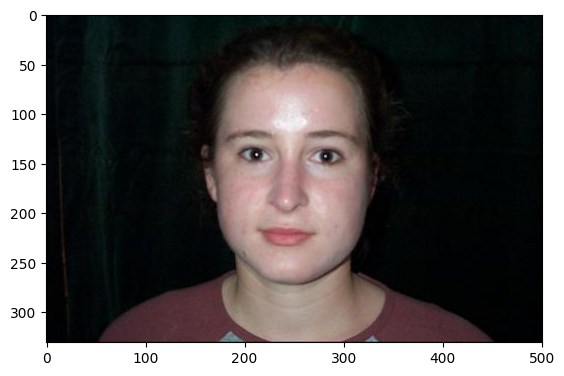

In [4]:
selected_latent_space = valid_latent_spaces[
    str(input("Enter latent space - one of " + str(list(valid_latent_spaces.keys()))))
]

selected_feature_model = valid_feature_models[
    str(input("Enter feature model - one of " + str(list(valid_feature_models.keys()))))
]

k = int(input("Enter value of k (no. of latent semantics): "))
if k < 1:
    raise ValueError("k should be a positive integer")

k_2 = int(input("Enter value of k_2 (no. of similar images): "))
if k_2 < 1:
    raise ValueError("k_2 should be a positive integer")

if selected_latent_space != "cp":
    selected_dim_reduction_method = str(
        input(
            "Enter dimensionality reduction method - one of "
            + str(list(valid_dim_reduction_methods.keys()))
        )
    )

selected_image_id = int(
    input("Enter image ID: (-1 if you want to select an image file)")
)
if selected_image_id == -1:
    # can't use image files for similarity matrices as they are fixed data
    if selected_latent_space in ["label_sim", "image_sim"]:
        raise Exception("Can't use image file for LS3, LS4 latent spaces")
    # pick image and get label using tkinter
    root = tkinter.Tk()
    root.attributes("-topmost", True)
    selected_image_path = askopenfilename(title="Select Image File")
    root.withdraw()
    print(selected_image_path)
    sample_image = read_image(selected_image_path).div(255)  # scale to [0,1] range
else:
    # can't use new image for fixed img-img sim matrix
    if selected_latent_space == "image_sim" and (selected_image_id % 2) != 0:
        raise Exception("Can't use odd-numbered image ID for image similarity matrix made from even-numbered image IDs")
    # get image and label from dataset
    sample_image, sample_label = dataset[selected_image_id]

# Show selected image
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()


In [5]:
# Loading latent semantics
match selected_latent_space:
    # LS1
    case "":
        file_prefix = f"{selected_feature_model}-{selected_dim_reduction_method}-{k}"
        file_name = file_prefix + "-semantics.json"
        model_name = file_prefix + "-model.joblib"
        if os.path.exists(file_name):
            data = json.load(open(file_name))
            print(file_name + " loaded")
        else:
            raise Exception(file_name + " does not exist")
        # LDA model
        if selected_dim_reduction_method == "lda":
            if os.path.exists(model_name):
                data_model = load(model_name)
                print(model_name + " loaded")
            else:
                raise Exception(model_name + " does not exist")
    # LS2
    case "cp":
        file_name = f"{selected_feature_model}-cp-{k}-semantics.json"
        if os.path.exists(file_name):
            data = json.load(open(file_name))
            print(file_name + " loaded")
        else:
            raise Exception(file_name + " does not exist")
    # LS3, LS4
    case _:
        file_name = f"{selected_latent_space}-{selected_feature_model}-{selected_dim_reduction_method}-{k}-semantics.json"
        if os.path.exists(file_name):
            data = json.load(open(file_name))
            print(file_name + " loaded")
        else:
            raise Exception(file_name + " does not exist")


cm_fd-svd-10-semantics.json loaded


In [11]:
def extract_similarities_ls1_ls4(
    latent_space, dim_reduction, selected_feature_model, data, image_id
):
    if image_id % 2:
        # not in database
        image_fd = np.array(get_all_fd(image_id)[selected_feature_model]).flatten()
    else:
        image_fd = np.array(
            fd_collection.find({"image_id": image_id})[selected_feature_model]
        ).flatten()

    match dim_reduction:
        case "svd":
            U = np.array(data["image-semantic"])
            S = np.array(data["semantics-core"])
            if len(S.shape) == 1:
                S = np.diag(S)
            V = np.transpose(np.array(data["semantic-feature"]))

            # 1 - Given data is multiplied with feature-semantic and core
            comparison_feature_space = np.matmul(U, S)

            if latent_space == "image_sim":
                # directly compare
                comparison_vector = comparison_feature_space[int(image_id / 2)]
            else:
                # 2 - Image-semantic is multiplied with core
                comparison_vector = np.matmul(np.matmul(image_fd, V), S)

        case "nmf":
            H = np.array(data["semantic-feature"])
            comparison_feature_space = np.array(data["image-semantic"])

            if latent_space == "image_sim":
                comparison_vector = comparison_feature_space[int(image_id / 2)]
            else:
                min_value = np.min(image_fd)
                feature_vectors_shifted = image_fd - min_value
                comparison_vector, _ = nmf(feature_vectors_shifted, k, H, update_H=False)

        case "kmeans":
            comparison_vector = []
            comparison_feature_space = np.array(data["image-semantic"])
            S = np.array(data["semantic-feature"])

            if latent_space == "image_sim":
                comparison_vector = comparison_feature_space[int(image_id / 2)]
            else:
                for centroid in S:
                    comparison_vector.append(math.dist(image_fd, centroid))

        case "lda":
            comparison_feature_space = np.array(data["image-semantic"])
            if latent_space == "image_sim":
                comparison_vector = comparison_feature_space[int(image_id / 2)]
            else:
                min_value = np.min(image_fd)
                feature_vectors_shifted = image_fd - min_value
                comparison_vector = data_model.transform(
                    feature_vectors_shifted.flatten().reshape(1, -1)
                ).flatten()
            
    distances = []
    for i in range(NUM_IMAGES):
        # skip target image
        if (i * 2) != image_id:
            if dim_reduction == "lda":
                # KL divergence
                distances.append(
                    {
                        "image_id": i * 2,
                        "label": all_images[i]["true_label"],
                        "distance": kl_divergence_measure(
                            comparison_vector, comparison_feature_space[i]
                        ),
                    }
                )
            else:
                # euclidean
                distances.append(
                    {
                        "image_id": i * 2,
                        "label": all_images[i]["true_label"],
                        "distance": math.dist(
                            comparison_vector, comparison_feature_space[i]
                        ),
                    }
                )

    distances = sorted(distances, key=lambda x: x["distance"], reverse=False)

    similar_labels = []
    unique_labels = set()

    for img in distances:
        if img["label"] not in unique_labels:
            similar_labels.append(img)
            unique_labels.add(img["label"])

            if len(similar_labels) == k_2:
                break

    for x in similar_labels:
        print(x)


In [12]:
def extract_similarities_ls2(data, image_id):

  IS = np.array(data["image-semantic"])
  S = np.array(data["semantics-core"])

  if len(S.shape) == 1:
    S = np.diag(S)

  comparison_feature_space = np.matmul(IS, S)
  comparison_vector = comparison_feature_space[int(image_id / 2)]

  distances = []

  n = len(comparison_feature_space)
  for i in range(n):
    if i != (image_id / 2):
      distances.append({"image_id": i * 2, "label":  all_images[i]["true_label"], "distance": math.dist(comparison_vector, comparison_feature_space[i])})
  
  distances = sorted(distances, key=lambda x: x["distance"], reverse=False)

  similar_labels = []
  unique_labels = set()

  for img in distances:
    if img["label"] not in unique_labels:
      similar_labels.append(img)
      unique_labels.add(img["label"])

      if len(similar_labels) == k_2:
        break


  for x in similar_labels:
    print(x)

In [13]:
def extract_similarities_ls3(dim_reduction, data, image_id):

  img_label = fd_collection.find({"image_id": image_id})["true_label"]

  if dim_reduction == "svd":
        U = np.array(data["image-semantic"])
        S = np.array(data["semantics-core"])
        V = np.transpose(np.array(data["semantic-feature"]))

        comparison_feature_space = np.matmul(U, S)
  else:
      comparison_feature_space = np.array(data["image-semantic"])
  
  comparison_vector = comparison_feature_space[img_label]

  distances = []
  for i in range(NUM_LABELS):
    if i != img_label:
      distances.append({"label": i, "distance": math.dist(comparison_vector, comparison_feature_space[i])})

  distances = sorted(distances, key=lambda x: x["distance"], reverse=False)[:k_2]

  for label in distances:
    print(label)

In [14]:
match selected_latent_space:

  case "" | "image_sim":
    
    extract_similarities_ls1_ls4(selected_latent_space, selected_dim_reduction_method, selected_feature_model, data, selected_image_id)

  case "label_sim":

    extract_similarities_ls3(selected_dim_reduction_method, data, selected_image_id)

  case "cp":

    extract_similarities_ls2(data, selected_image_id)


{'image_id': 124, 'label': 0, 'distance': 0.4148529606356992}
{'image_id': 4920, 'label': 39, 'distance': 1.676182057636327}
{'image_id': 5228, 'label': 45, 'distance': 1.8250992738304608}
{'image_id': 7748, 'label': 87, 'distance': 2.1685026820679094}
{'image_id': 7212, 'label': 78, 'distance': 2.227285100342999}
{'image_id': 5702, 'label': 52, 'distance': 2.2295842822364613}
{'image_id': 4564, 'label': 34, 'distance': 2.237135101448168}
{'image_id': 3160, 'label': 13, 'distance': 2.2593077151660474}
{'image_id': 3276, 'label': 15, 'distance': 2.2697839276364635}
{'image_id': 3396, 'label': 16, 'distance': 2.352119717303774}
